In [1]:
!pip install --quiet biosppy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 kB 1.7 MB/s eta 0:00:00


In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
import cv2
import numpy as np
import pandas as pd
from scipy import signal
import os
import matplotlib.pyplot as plt

# Additional libraries for feature extraction from ECG
from biosppy.signals import ecg

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, TimeDistributed
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Bidirectional, LSTM, Concatenate, Input
from keras.optimizers import Adam
import keras

## Video

#### Gaber Wavelets

In [111]:
def generate_gabor_wavelets(rows, cols, orientation, scale, max_freq = np.pi/2, freq = np.sqrt(2), sigma = (2*np.pi)**2):
    """
    Args:
        rows (int): Number of rows in the kernel.
        cols (int): Number of columns in the kernel.
        kmax (float): Maximum frequency.
        f (float): Frequency parameter.
        orientation (float): Orientation of the Gabor wavelet.
        scale (float): Scale parameter.
        sigma (float): Standard deviation of the Gaussian envelope.

    Returns:
        np.ndarray: Gabor wavelet kernel.
    """
    # Compute the complex wave number
    k = (max_freq / (freq ** scale)) * np.exp(1j * orientation * np.pi / 8)
    kn2 = np.abs(k) ** 2

    # Initialize the Gabor wavelet kernel
    gw = np.zeros((rows, cols), np.complex128)

    # Compute the Gabor wavelet kernel
    for m in range(int(-rows/2) + 1, int(rows / 2) + 1):
        for n in range(int(-cols/2) + 1, int(cols / 2) + 1):
            t1 = np.exp(-0.5 * kn2 * (m**2 + n**2) / sigma)
            t2 = np.exp(1j * (np.real(k) * m + np.imag(k) * n))
            t3 = np.exp(-0.5 * sigma)
            gw[int(m + rows/2 - 1), int(n + cols/2 - 1)] = (kn2 / sigma) * t1 * (t2 - t3)

    return gw

In [112]:
# R, C = (128, 128)
# For scale 1 to 5
# Orientation 1 to 8 storing all the gaber_wavelets
gaber_wavelets = []
for i in range(1, 6):
    gw = []
    for j in range(1, 9):
        gw.append(generate_gabor_wavelets(128, 128, i, j))
    gaber_wavelets.append(gw)

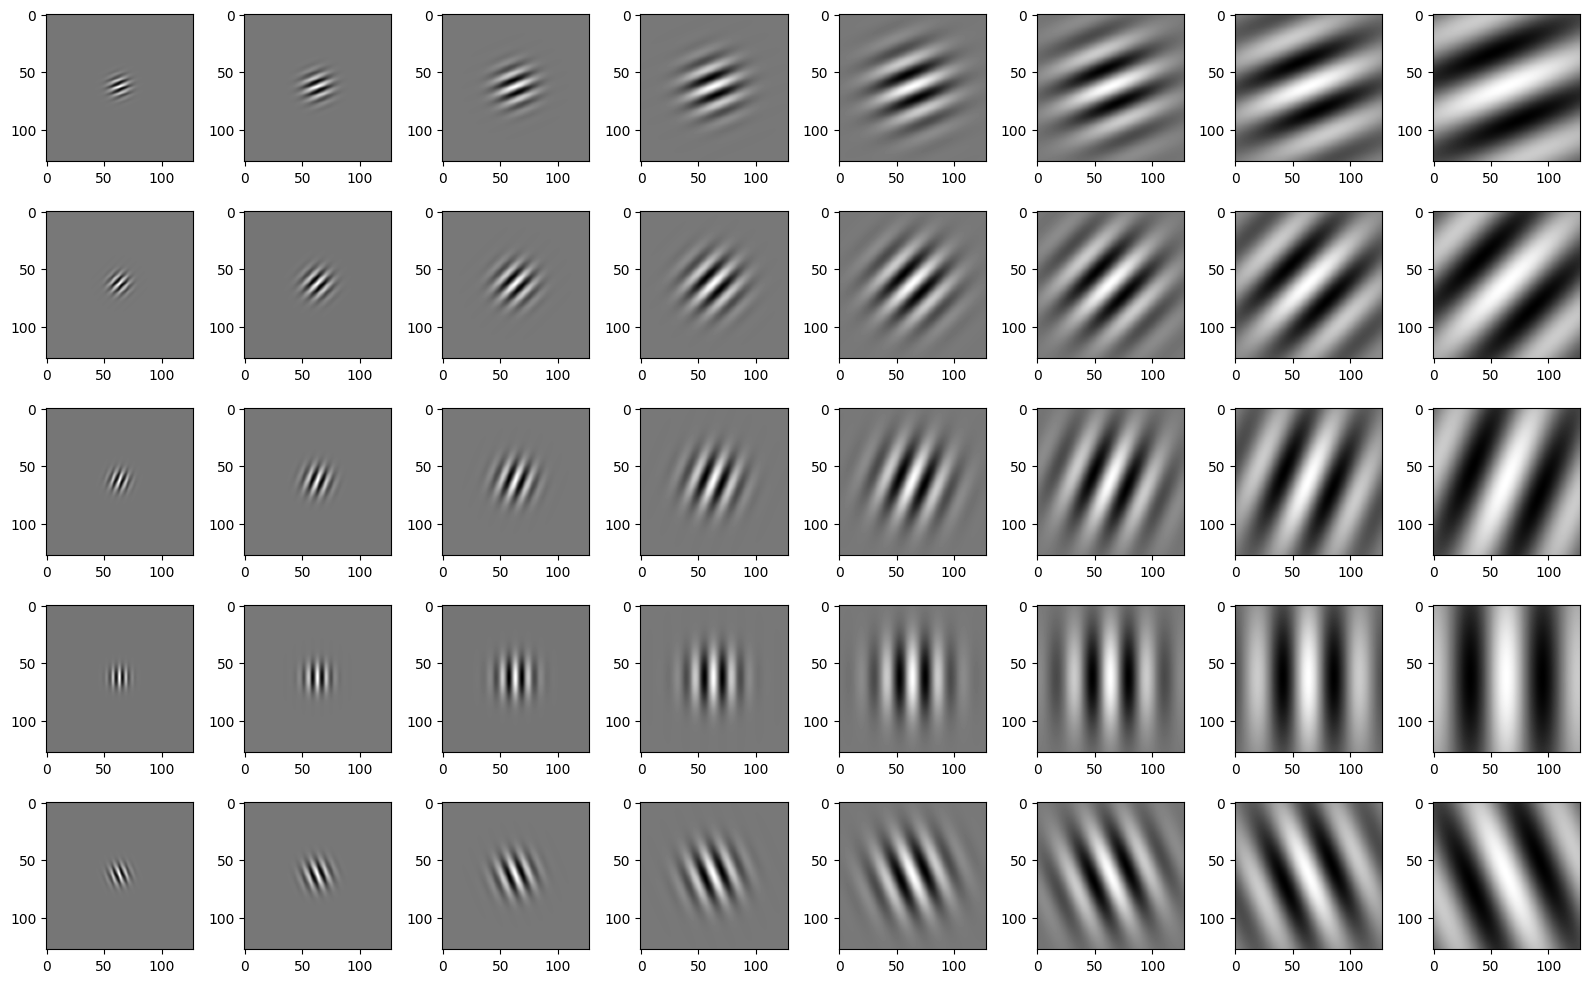

In [113]:
# Plotting the gaber_wavelets
fig, axs = plt.subplots(5, 8, figsize=(16, 10))
for i in range(5):
    for j in range(8):
        axs[i, j].imshow(np.real(gaber_wavelets[i][j]), cmap='gray')

plt.tight_layout()
plt.show()

In [114]:
def apply_gabor_filters(frame, gaber_wavelets):
    gabor_features = []
    for i in range(5):
        for j in range(8):
            resultR = cv2.filter2D(frame, cv2.CV_32F, np.real(gaber_wavelets[i][j]))
            resultI = cv2.filter2D(frame, cv2.CV_32F, np.imag(gaber_wavelets[i][j]))
            result = np.hypot(resultI, resultR)
            gabor_features.append(result)
    return gabor_features

In [115]:
def plot_subplots(array_list):
    fig, axs = plt.subplots(5, 8, figsize=(16, 10))
    for i in range(5):
        for j in range(8):
            index = i * 8 + j
            if index < len(array_list):
                axs[i, j].imshow(array_list[index], cmap='gray')

    plt.tight_layout()
    plt.show()

In [123]:
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // 60

    frames = []
    count = 0

    # Loop through the video frames
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cropped_frame = gray_frame[:, 200:1080]

        # Resize the frame to 128x128 and append
        resized_frame = cv2.resize(cropped_frame, (128, 128))
        frames.append(resized_frame)

        # Check if the desired number of frames is reached
        count += 1
        if count == 240:
            break

        cap.set(cv2.CAP_PROP_POS_FRAMES, count * interval)

    cap.release()
    frames = np.array(frames) / 255.0  # Normalize to [0, 1] range

    return frames

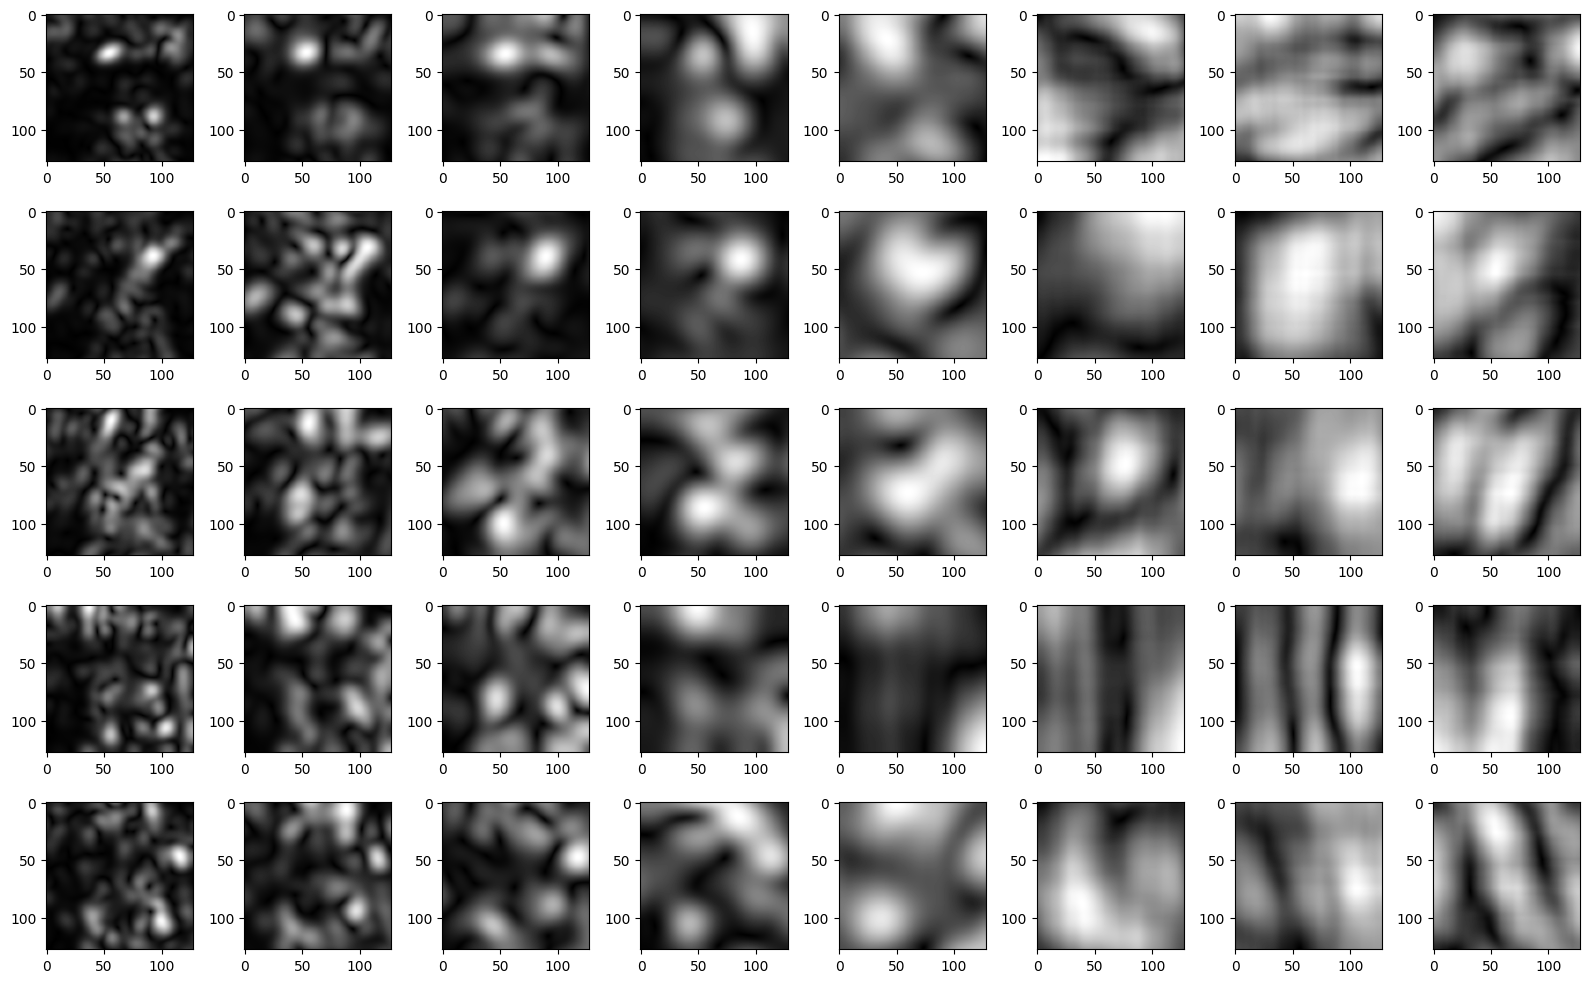

In [126]:
# Extracting a frame
video_path = '/content/drive/MyDrive/Driver_database/Baseline/Subject1/Subject1/subject1_2_minutes.mp4'
video_data = preprocess_video(video_path)

# Plotting the gabor filters of frame 1 of the first video
frame1 = video_data[0]
gabor_features_frame1 = apply_gabor_filters(frame1, gaber_wavelets)
plot_subplots(gabor_features_frame1)

In [127]:
def apply_pca(features, n_components=40):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features

In [128]:
# Define the base directory of your dataset
base_dir = '/content/drive/MyDrive/Driver_database'

# Define the list of subjects and emotions
subjects = [f'Subject{i}' for i in range(1, 11)]
emotions = ['Baseline', 'Cognitive', 'Emotional', 'Normal']

video_data = []
labels = []

# Loop through each subject and each emotion
for subject in subjects:
    for emotion in emotions:
        # Construct the paths for the video and ECG files
        subject_dir = os.path.join(base_dir, emotion, subject, subject)
        video_path = os.path.join(subject_dir, f'{subject.lower()}_2_minutes.mp4')

        # Preprocess the video data
        video_ = preprocess_video(video_path)
        split_parts = np.split(video_, 4, axis=0)

        if tf.test.is_gpu_available():
            # Train the model on GPU
            with tf.device('/GPU:0'):
                for part in split_parts:
                    new_part = []
                    for frame in part:
                        gabor_features = apply_gabor_filters(frame, gaber_wavelets)
                        flattened_features = [i.flatten() for i in gabor_features]
                        reduced_features = apply_pca(flattened_features)
                        new_part.append(reduced_features)
                    # Append the combined data to the data list
                    video_data.append(new_part)
                    labels.append(emotion)
        else:
            # Train the model on CPU
            for part in split_parts:
                new_part = []
                for frame in part:
                    gabor_features = apply_gabor_filters(frame, gaber_wavelets)
                    flattened_features = [i.flatten() for i in gabor_features]
                    reduced_features = apply_pca(flattened_features)
                    new_part.append(reduced_features)
                # Append the combined data to the data list
                video_data.append(new_part)
                labels.append(emotion)
        print(subject, emotion)

Subject1 Baseline
Subject1 Cognitive
Subject1 Emotional
Subject1 Normal
Subject2 Baseline
Subject2 Cognitive
Subject2 Emotional
Subject2 Normal
Subject3 Baseline
Subject3 Cognitive
Subject3 Emotional
Subject3 Normal
Subject4 Baseline
Subject4 Cognitive
Subject4 Emotional
Subject4 Normal
Subject5 Baseline
Subject5 Cognitive
Subject5 Emotional
Subject5 Normal
Subject6 Baseline
Subject6 Cognitive
Subject6 Emotional
Subject6 Normal
Subject7 Baseline
Subject7 Cognitive
Subject7 Emotional
Subject7 Normal
Subject8 Baseline
Subject8 Cognitive
Subject8 Emotional
Subject8 Normal
Subject9 Baseline
Subject9 Cognitive
Subject9 Emotional
Subject9 Normal
Subject10 Baseline
Subject10 Cognitive
Subject10 Emotional
Subject10 Normal


In [129]:
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(labels)
x_data = np.asarray(video_data)
X = x_data.reshape((160, 15, -1))

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)

In [131]:
X.shape

(160, 15, 1600)

In [138]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define your CNN model architecture
model = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(15, 1600)),
    layers.MaxPooling1D(2),
    layers.Dropout(0.25),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(4, activation='softmax')  # num_classes is the number of emotion classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_train, y_train))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/10
4/4 [==============================] - 1s 93ms/step - loss: 1.7114 - accuracy: 0.2734 - val_loss: 1.0992 - val_accuracy: 0.5625
Epoch 2/10
4/4 [==============================] - 0s 19ms/step - loss: 1.0372 - accuracy: 0.5938 - val_loss: 0.8821 - val_accuracy: 0.7422
Epoch 3/10
4/4 [==============================] - 0s 18ms/step - loss: 0.8593 - accuracy: 0.7109 - val_loss: 0.6238 - val_accuracy: 0.8984
Epoch 4/10
4/4 [==============================] - 0s 17ms/step - loss: 0.6112 - accuracy: 0.8281 - val_loss: 0.3903 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 0s 21ms/step - loss: 0.4308 - accuracy: 0.9453 - val_loss: 0.2473 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s 21ms/step - loss: 0.3296 - accuracy: 0.9375 - val_loss: 0.1586 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 0s 16ms/step - loss: 0.2141 - accuracy: 0.9609 - val_loss: 0.1009 - val_accuracy: 1.0000
Epoch 8/10
4/4 [===========

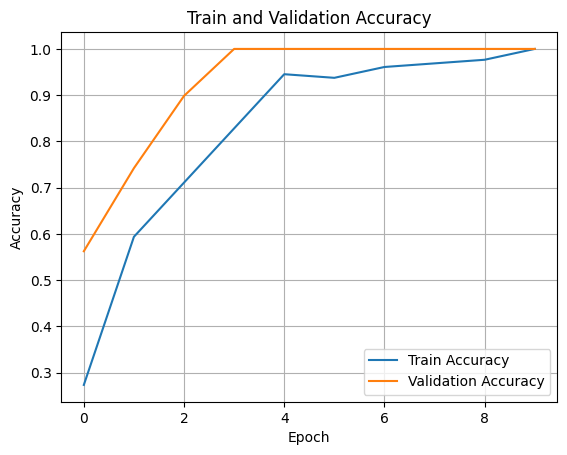

In [139]:
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [140]:
# Confusion Matrix
y_true = y_test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print(conf_matrix_percentage)

1/1 [==============================] - 0s 153ms/step
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.14285714 0.14285714 0.57142857 0.14285714]
 [0.         0.3        0.1        0.6       ]]


In [141]:
y_true = y_test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)

1/1 [==============================] - 0s 54ms/step
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.56      1.00      0.71         5
           2       0.80      0.57      0.67         7
           3       0.86      0.60      0.71        10

    accuracy                           0.78        32
   macro avg       0.78      0.79      0.76        32
weighted avg       0.81      0.78      0.78        32



## ECG

In [23]:
# Define the base directory of your dataset
base_dir = '/content/drive/MyDrive/Driver_database'

# Define the list of subjects and emotions
subjects = [f'Subject{i}' for i in range(1, 11)]
emotions = ['Baseline', 'Cognitive', 'Emotional', 'Normal']

def preprocess_ecg(ecg_path):
    output = []
    ecg_data = pd.read_csv(ecg_path, header = None)
    ecg_data.columns = ['ECG']
    ecg_readings = ecg_data['ECG'].values

    parts = np.array_split(ecg_readings, 4)

    for i, part in enumerate(parts):
        # Extract features using the biosppy library
        out = ecg.ecg(signal=part, sampling_rate=1000, show=False)
        heart_rate = out['filtered']

        # Frequency-domain features using Welch's method
        freqs, psd = signal.welch(ecg_readings, fs=1000)

        features = np.concatenate((heart_rate, psd))
        scaler = StandardScaler()
        features_standardized = scaler.fit_transform(features.reshape(-1, 1))

        output.append(features_standardized.flatten())
    return output

data1 = []
labels1 = []

for subject in subjects:
    for emotion in emotions:
        subject_dir = os.path.join(base_dir, emotion, subject, subject)
        ecg_path = os.path.join(subject_dir, 'Min2_groundtruth.csv')

        # Preprocess the ECG data
        ecg_features = preprocess_ecg(ecg_path)

        for i in ecg_features:
          data1.append(i)
          labels1.append(emotion)

        print(subject, emotion)

Subject1 Baseline
Subject1 Cognitive
Subject1 Emotional
Subject1 Normal
Subject2 Baseline
Subject2 Cognitive
Subject2 Emotional
Subject2 Normal
Subject3 Baseline
Subject3 Cognitive
Subject3 Emotional
Subject3 Normal
Subject4 Baseline
Subject4 Cognitive
Subject4 Emotional
Subject4 Normal
Subject5 Baseline
Subject5 Cognitive
Subject5 Emotional
Subject5 Normal
Subject6 Baseline
Subject6 Cognitive
Subject6 Emotional
Subject6 Normal
Subject7 Baseline
Subject7 Cognitive
Subject7 Emotional
Subject7 Normal
Subject8 Baseline
Subject8 Cognitive
Subject8 Emotional
Subject8 Normal
Subject9 Baseline
Subject9 Cognitive
Subject9 Emotional
Subject9 Normal
Subject10 Baseline
Subject10 Cognitive
Subject10 Emotional
Subject10 Normal


In [26]:
mini = np.min([len(i) for i in data1])
maxi = np.max([len(i) for i in data1])

data = [i[:mini] for i in data1]
labels = labels1

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels1)

In [27]:
data = np.asarray(data)
data.shape

(160, 15155)

In [82]:
# Step 5: Training
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [83]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [84]:
X_train.shape

(128, 15155)

In [85]:
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

label_encoder = LabelEncoder()
YTrain_encoded = label_encoder.fit_transform(y_train)
YTest_encoded = label_encoder.transform(y_test)

In [96]:
import torch

def create_bilstm_model(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=False), input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model = create_bilstm_model(input_shape=Xtrain.shape[1:], num_classes=4)

if tf.test.is_gpu_available():
    # Train the model on GPU
    with tf.device('/GPU:0'):
        model.fit(Xtrain, YTrain_encoded, epochs=5, batch_size=32, validation_data=(Xtest, YTest_encoded))
else:
    # Train the model on CPU
    model.fit(Xtrain, YTrain_encoded, epochs=5, batch_size=32, validation_data=(Xtest, YTest_encoded))

Epoch 1/5
4/4 [==============================] - 11s 1s/step - loss: 1.3863 - accuracy: 0.2812 - val_loss: 1.3932 - val_accuracy: 0.1875
Epoch 2/5
4/4 [==============================] - 4s 1s/step - loss: 1.3730 - accuracy: 0.3672 - val_loss: 1.3991 - val_accuracy: 0.1875
Epoch 3/5
4/4 [==============================] - 3s 865ms/step - loss: 1.3595 - accuracy: 0.4062 - val_loss: 1.3958 - val_accuracy: 0.2500
Epoch 4/5
4/4 [==============================] - 4s 975ms/step - loss: 1.3335 - accuracy: 0.4141 - val_loss: 1.2074 - val_accuracy: 0.4375
Epoch 5/5
4/4 [==============================] - 4s 998ms/step - loss: 1.2158 - accuracy: 0.5000 - val_loss: 1.1515 - val_accuracy: 0.5000


In [97]:
with tf.device('/GPU:0'):
        model.fit(Xtrain, YTrain_encoded, epochs=5, batch_size=32, validation_data=(Xtest, YTest_encoded))

Epoch 1/5
4/4 [==============================] - 4s 943ms/step - loss: 1.2547 - accuracy: 0.4453 - val_loss: 1.1063 - val_accuracy: 0.4688
Epoch 2/5
4/4 [==============================] - 4s 973ms/step - loss: 1.1885 - accuracy: 0.4375 - val_loss: 1.1891 - val_accuracy: 0.4062
Epoch 3/5
4/4 [==============================] - 3s 872ms/step - loss: 1.1919 - accuracy: 0.4766 - val_loss: 1.2279 - val_accuracy: 0.4375
Epoch 4/5
4/4 [==============================] - 4s 1s/step - loss: 1.1353 - accuracy: 0.4922 - val_loss: 1.1050 - val_accuracy: 0.4375
Epoch 5/5
4/4 [==============================] - 3s 879ms/step - loss: 1.0486 - accuracy: 0.5078 - val_loss: 1.1032 - val_accuracy: 0.4688


In [98]:
with tf.device('/GPU:0'):
        model.fit(Xtrain, YTrain_encoded, epochs=5, batch_size=32, validation_data=(Xtest, YTest_encoded))

Epoch 1/5
4/4 [==============================] - 4s 893ms/step - loss: 1.2126 - accuracy: 0.4141 - val_loss: 1.0878 - val_accuracy: 0.4062
Epoch 2/5
4/4 [==============================] - 4s 1s/step - loss: 1.1659 - accuracy: 0.4219 - val_loss: 1.0454 - val_accuracy: 0.4375
Epoch 3/5
4/4 [==============================] - 4s 977ms/step - loss: 1.0449 - accuracy: 0.5000 - val_loss: 1.0806 - val_accuracy: 0.4375
Epoch 4/5
4/4 [==============================] - 3s 879ms/step - loss: 1.0541 - accuracy: 0.5078 - val_loss: 1.1535 - val_accuracy: 0.4375
Epoch 5/5
4/4 [==============================] - 4s 1s/step - loss: 1.1944 - accuracy: 0.4766 - val_loss: 1.1152 - val_accuracy: 0.4688


# Fused Model

In [28]:
# Data Generation
import random
unique_random_numbers = random.sample(range(0, 160), 32)

In [29]:
combined_video_train = []
combined_ecg_train = []
combined_labels_train = []

combined_video_test = []
combined_ecg_test = []
combined_labels_test = []

for i in range(160):
    if(i in unique_random_numbers):
        combined_video_test.append(X[i])
        combined_ecg_test.append(data[i])
        combined_labels_test.append(labels[i])
    else:
        combined_video_train.append(X[i])
        combined_ecg_train.append(data[i])
        combined_labels_train.append(labels[i])

In [30]:
combined_video_train = np.asarray(combined_video_train)
combined_video_test = np.asarray(combined_video_test)

combined_ecg_train = np.asarray(combined_ecg_train)
combined_ecg_train = combined_ecg_train.reshape((combined_ecg_train.shape[0], combined_ecg_train.shape[1], 1))

combined_ecg_test = np.asarray(combined_ecg_test)
combined_ecg_test = combined_ecg_test.reshape((combined_ecg_test.shape[0], combined_ecg_test.shape[1], 1))
print(combined_ecg_test.shape)

(32, 15155, 1)


In [31]:
combined_labels_test = np.asarray(combined_labels_test)
combined_labels_train = np.asarray(combined_labels_train)

print(combined_labels_test.shape)

(32,)


In [72]:
num_classes = 4
ecg_input_shape = (15155, 1)  # Example shape

# Define CNN model for video processing
cnn_input = Input(shape=(15, 1600))
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.2),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(16, activation='relu'),
])

cnn_output = cnn_model(cnn_input)

# Define BiLSTM model
ecg_input = Input(shape=ecg_input_shape)
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
])

bilstm_output = bilstm_model(ecg_input)

# Concatenate feature vectors from both models
combined_features = Concatenate()([cnn_output, bilstm_output])

# Define neural network for emotion classification
emotion_model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
emotion_output = emotion_model(combined_features)

# Create the combined model
combined_model = Model(inputs=[cnn_input, ecg_input], outputs=emotion_output)
opt = keras.optimizers.Adam(learning_rate = 0.01)
combined_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the combined model using the concatenated features as input
hist = combined_model.fit([combined_video_train, combined_ecg_train], combined_labels_train, epochs=12, validation_data=([combined_video_test, combined_ecg_test], combined_labels_test))

# Evaluate the combined model
test_loss, test_acc = combined_model.evaluate([combined_video_test, combined_ecg_test], combined_labels_test)
print('Test accuracy:', test_acc)

Epoch 1/10
4/4 [==============================] - 2s 78ms/step - loss: 1.6450 - accuracy: 0.2578 - val_loss: 1.1121 - val_accuracy: 0.5391
Epoch 2/10
4/4 [==============================] - 0s 18ms/step - loss: 1.1258 - accuracy: 0.5156 - val_loss: 0.8747 - val_accuracy: 0.7734
Epoch 3/10
4/4 [==============================] - 0s 21ms/step - loss: 0.8483 - accuracy: 0.7109 - val_loss: 0.6552 - val_accuracy: 0.8828
Epoch 4/10
4/4 [==============================] - 0s 22ms/step - loss: 0.6263 - accuracy: 0.8828 - val_loss: 0.4391 - val_accuracy: 0.9531
Epoch 5/10
4/4 [==============================] - 0s 23ms/step - loss: 0.4212 - accuracy: 0.9219 - val_loss: 0.2782 - val_accuracy: 0.9609
Epoch 6/10
4/4 [==============================] - 0s 18ms/step - loss: 0.3384 - accuracy: 0.9453 - val_loss: 0.1724 - val_accuracy: 0.9688
Epoch 7/10
4/4 [==============================] - 0s 17ms/step - loss: 0.2254 - accuracy: 0.9766 - val_loss: 0.1058 - val_accuracy: 0.9922
Epoch 8/10
4/4 [===========

In [81]:
# Confusion Matrix
y_true = combined_labels_test
y_pred = combined_model.predict([combined_video_test, combined_ecg_test])
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print(conf_matrix_percentage)

1/1 [==============================] - 0s 51ms/step
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.71428571 0.28571429]
 [0.1        0.1        0.1        0.7       ]]


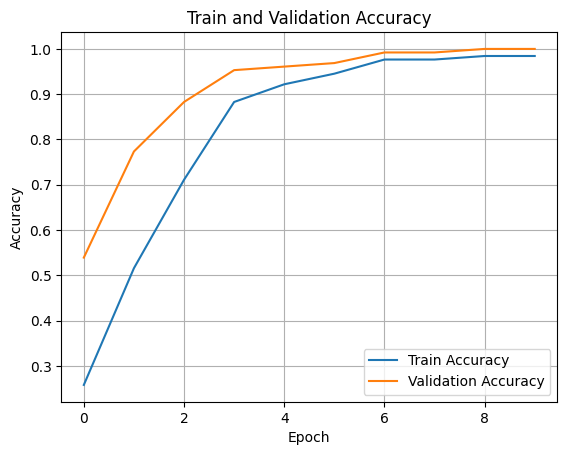

In [100]:
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()